In [1]:
from aicsimageio import AICSImage
from skimage.feature import peak_local_max
import pyclesperanto_prototype as cle
import napari
import os
import numpy as np
import pandas as pd

In [2]:
def segmentation(image, threshold, zoom_factor):
    
    #Noise removal
    g_blur = cle.gaussian_blur(image, sigma_x=1, sigma_y=1, sigma_z=1)
    
    #background subtracton
    background_subtracted = np.asarray(cle.top_hat_box(g_blur, radius_x=2*zoom_factor, radius_y=2*zoom_factor, radius_z=2*zoom_factor))
    del g_blur
    
    #threshold = threshold_otsu(background_subtracted)
    peaks = peak_local_max(background_subtracted, threshold_abs=threshold, min_distance=2)
    
    # Find local peaks above the specified threshold
    spots = cle.create(image.shape, dtype=np.uint32)
    peaks = peaks[:,::-1]
        
    # Convert the list of peaks to a labeled image
    labeled_spots = cle.pointlist_to_labelled_spots(peaks.T, spots)
    
    # Expand the labeled spots by a certain radius
    expanded_labels = cle.dilate_labels(labeled_spots, radius=5)
    
    #Create a binary mask where all pixels above half of the maximum intensity in each labels are 1
    #This is done to perform full-width half-maxima for estimating foci boundary
    threshold_map = cle.maximum_intensity_map(background_subtracted, expanded_labels) / 2
    thresholded_image = np.asarray(background_subtracted) > np.asarray(threshold_map)
    
    labeled_foci = (expanded_labels * thresholded_image).astype(np.uint32)
    
    #Exclude small labels
    output_labels = cle.exclude_small_labels(labeled_foci, None, 10.0)
    
    del peaks
    del background_subtracted
    del spots
    del labeled_spots
    del labeled_whatever
    del expanded_labels
    del threshold_map
    del thresholded_image
    del image
    
    return output_labels

0.15 0.03531572274300255 0.03531572274300255


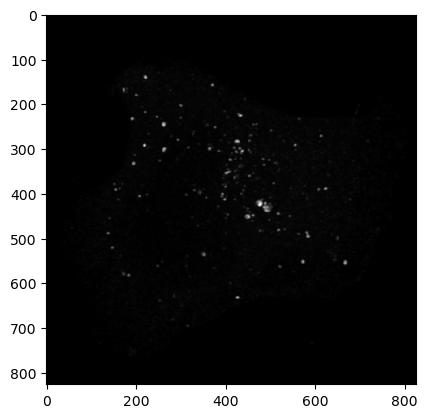

In [15]:
image_path = "C:/Nisarg/Thesis/Data/#4722 - 25.04.2023/#4722_07_W33-M66_native_zstack_0.5%_airy.czi"

aics_image = AICSImage(image_path)
image = aics_image.get_image_data("ZYX", T=0, C=0)

Voxel_size_z = aics_image.physical_pixel_sizes.Z
Voxel_size_y = aics_image.physical_pixel_sizes.Y
Voxel_size_x = aics_image.physical_pixel_sizes.X
print(Voxel_size_z, Voxel_size_y, Voxel_size_x)

cle.imshow(full_image, labels=False)

In [16]:
image = image/image.max()

In [17]:
zoom_factor=3 #Maximum upto 4.28 (Voxel.size.z / Voxel.size.x = 4.28)

#Rescale to isotropic
rescaled = cle.scale(image, factor_x= zoom_factor*(Voxel_size_x/Voxel_size_z), factor_y= zoom_factor*(Voxel_size_y/Voxel_size_z), factor_z= zoom_factor*(1.0), auto_size= True)
pixel_volume = pow((Voxel_size_z / zoom_factor), 3)

del image
rescaled.shape

(126, 583, 583)

In [18]:
threshold = 0.04

In [19]:
labels = segmentation(rescaled, threshold, zoom_factor)

In [20]:
viewer = napari.Viewer()
viewer.add_image(rescaled)


<Image layer 'rescaled' at 0x13f6ed224f0>

In [21]:
viewer.add_labels(labels)

<Labels layer 'labels' at 0x13f6c963970>

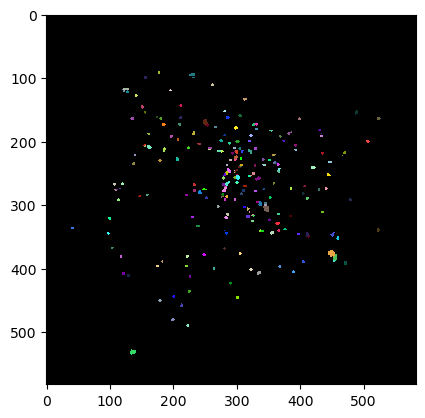

In [22]:
cle.imshow(labels, labels=True)